# Quantum Approximate Optimization Algorithm

This notebook demonstrates the implementation of the Quantum Approximate Optimization Algorithm ([QAOA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html)) for a graph partitioning problem (finding the maximum cut), and compares it to a solution using the brute-force approach.

Our goal is to partition the graph's vertices into two complementary sets, such that the number of edges between the sets is as large as possible. First, we define the graph using an adjacency matrix, this matrix defines the connectivity between nodes. We draw it to visualize the nodes and edges of the graph.

In [1]:
import numpy as np
import networkx as nx

num_nodes = 4

# Adjacency matrix. Each vector element corresponds to one node.
# Inside the vector element there are the different connections 
w = np.array(
    [[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0]]
)
G = nx.from_numpy_array(w)

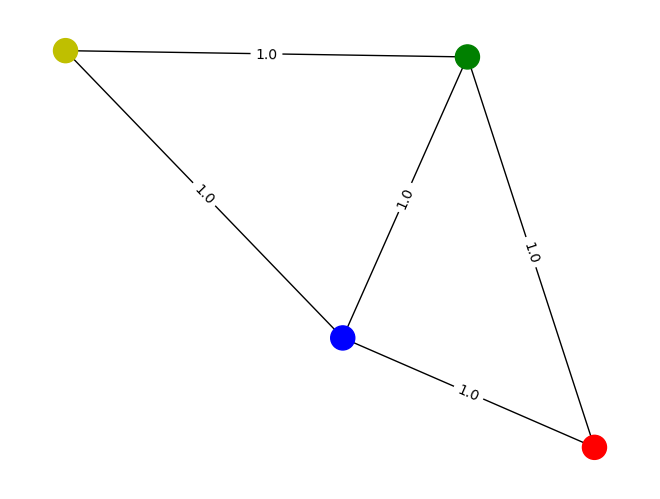

In [2]:
layout = nx.random_layout(G, seed=10)
colors = ["r", "g", "b", "y"]
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

The brute-force method is as follows. Basically, we exhaustively try all the binary assignments. In each binary assignment, the entry of a vertex is either 0 (meaning the vertex is in the first partition) or 1 (meaning the vertex is in the second partition). We print the binary assignment that satisfies the definition of the graph partition and corresponds to the minimal number of crossing edges.

In [3]:
def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)


def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]


# use the brute-force way to generate the oracle
L = num_nodes
maximum = 2**L
sol = np.inf
for i in range(maximum):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue    #skips everything to the next iteration

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f"Objective value computed by the brute-force method is {sol}")

Objective value computed by the brute-force method is 3


The graph partition problem can be converted to an Ising Hamiltonian, as is done in the following cell. Since the goal is to show QAOA, this conversion module is used to create the operator without further explanation. The paper [Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843) may be of interest if you would like to understand the technique further. Another resource can be the Qiskit Optimization package, which contains functionality to do this conversion automatically for several optimization problems.

In [6]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)
print(qubit_op, offset)

SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IIZZ', 'IZZI', 'ZIZI', 'IZIZ', 'IZZI', 'ZZII', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j]) 6.5


So lets use the QAOA algorithm to find the solution.

In [7]:
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = StatevectorSampler(seed=42)


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: Quasi-distribution.

    Returns:
        Array of bits.
    """
    return np.array([int(bit) for bit in max(state_vector.items(), key=lambda x: x[1])[0][::-1]])


algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")

c:\Users\Gregor\anaconda3\envs\vqe-jupyter\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\Gregor\anaconda3\envs\vqe-jupyter\lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
c:\Users\Gregor\anaconda3\envs\vqe-jupyter\lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[1 1 0 0]
Objective value computed by QAOA is 3


The outcome can be seen to match to the value computed above by brute force. But we can also use the classical `NumPyMinimumEigensolver` to do the computation, which may be useful as a reference without doing things by brute force.

In [8]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.quantum_info import Operator

npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(Operator(qubit_op))

x = sample_most_likely(result.eigenstate.probabilities_dict())

print(x)
print(f"Objective value computed by the NumPyMinimumEigensolver is {objective_value(x, w)}")

[1 1 0 0]
Objective value computed by the NumPyMinimumEigensolver is 3


It is also possible to use SamplingVQE as shown below, which offers an alternative solution to the problem.

In [9]:
from qiskit.circuit.library import n_local

from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 13345

optimizer = COBYLA()
ansatz = n_local(qubit_op.num_qubits, "ry", "cz", reps=2, entanglement="linear")
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer)

result = sampling_vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by SamplingVQE is {objective_value(x, w)}")

[0 1 0 1]
Objective value computed by SamplingVQE is 3


## Transpiling options

The `QAOA` class doesn't expose the quantum circuit it uses to the user. However, this may lead to problems when running on actual quantum hardware, since the quantum circuit has to be transpiled beforehand. In order to still let the user choose the transpilation method and its properties in general, it is possible to pass to the `QAOA` class a `Transpiler`, which is any object having a `run` method that can transpile a `QuantumCircuit` into one another, or a list of `QuantumCircuit` into one another.

For instance, let us define a custom backend on four qubits like so.

In [10]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(0, 1), (1, 2), (2, 3)]
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_map, seed=54)

Let us define a `PassManager` for this backend.

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

We can then pass this `PassManager` to the `transpiler` keyword argument of the `QAOA` constructor. We can also pass any options to the `run` method of the `Transpiler` by setting the `transpiler_options` keyword argument to a dictionary specifying said options. For instance, let us define a `callback` function that prints out that it has been called on the very first step of the transpilation.

In [12]:
def callback(**kwargs):
    if kwargs["count"] == 0:
        print(f"Callback function has been called!")

We can then instantiate and use the `QAOA` class like so.

In [ ]:
qaoa = QAOA(sampler, optimizer, reps=2, transpiler=pm, transpiler_options={"callback": callback})
result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")       #Sometimes it fails! Not 100% accurate

Callback function has been called!


c:\Users\Gregor\anaconda3\envs\vqe-jupyter\lib\site-packages\qiskit\circuit\quantumcircuit.py:4625: UserWarning: Trying to add QuantumRegister to a QuantumCircuit having a layout
  circ.add_register(qreg)


[0 1 0 1]
Objective value computed by QAOA is 3


In [21]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright

ModuleNotFoundError: No module named 'tutorial_magics'